# Computational steps to extract nucleosome's DNA sequences and patterns

## Obtain DNA sequences from given genomic coordinates

This section shows how to use bash commands and bedtools to obtain fasta file of nucleosome's DNA sequences from the file of their genomic coordinates. In this example source nucleosome file is in folder data under file name GSM3718063_HepG2_Male.nucleosome.peak.bed .

Genome-wide the nucleosomes are very dense and represent all genome. To compute patterns in nucleosomes we need to select the well phased nucleosomes that are in the vicinity of gene transcription start sites. In this example annotation file is in folder data under file name gencode.v45lift37.basic.annotation.gtf . 

To obtain sequences from genomic coordinates we need a reference genome gh19. It can be downloaded from UCSC genome browser. Since nucleosome regions are only 140 bp long we need to add 30 bp from each end of the region. For this reason we will need chromosome sizes of the hg19 genome. 

To extract sequences we will need to index the reference genome. This is done only one time. 

In [1]:
# content of example folder with all necessary files
ls

annot.bed
annot.sorted.bed
data
dnpatterntools
nuc.bed
nuc.closest.bed
nuc.closest.coord.bed
nuc.closest.coord.extended.bed
nuc.closest.fasta
nuc.correlations.tabular
nuc.diprofiles.plot.png
nuc.diprofiles.selected.symmetrized.composite.smoothed.tabular
nuc.diprofiles.selected.symmetrized.composite.tabular
nuc.diprofiles.selected.symmetrized.tabular
nuc.diprofiles.selected.tabular
nuc.diprofiles.tabular
nuc.sorted.bed
smoothed_composites_plot.png
snap
steps_to_obtain_patterns.ipynb


In [2]:
ls data

gencode.v45lift37.basic.annotation.gtf     hg19
GSM3718063_HepG2_Male.nucleosome.peak.bed


In [4]:
# filter gene annotations and create a bed file
cat  data/gencode.v45lift37.basic.annotation.gtf | grep "protein_coding" | grep -v CDS  | grep -v exon | grep -v intron  | grep -v UTR | grep -v transcript | cut -f2,3,6,8 --complement > annot.bed

In [3]:
# inspect the result and count how many genes
head -n3 annot.bed
echo ""
echo "genes in annot.bed"
wc -l annot.bed

chr1	65419	71585	+	gene_id "ENSG00000186092.7_9"; gene_type "protein_coding"; gene_name "OR4F5"; level 2; hgnc_id "HGNC:14825"; havana_gene "OTTHUMG00000001094.4_9"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";
chr1	134901	139379	-	gene_id "ENSG00000237683.5"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "AL627309.1"; level 3; remap_substituted_missing_target "V19";
chr1	367640	368634	+	gene_id "ENSG00000235249.1"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "OR4F29"; level 2; havana_gene "OTTHUMG00000002860.1"; remap_substituted_missing_target "V19";

genes in annot.bed
20173 annot.bed


In [11]:
# in order to find closest nucleosome regions to genes both files must be sorted
# bedtools sorting does not sort properly, we use a simple sort
sort -k1,1 -k2,2n annot.bed > annot.sorted.bed
sort -k1,1 -k2,2n data/GSM3718063_HepG2_Male.nucleosome.peak.bed > nuc.sorted.bed

# inspect the result
head *.sorted.bed

==> annot.sorted.bed <==
chr1	65419	71585	+	gene_id "ENSG00000186092.7_9"; gene_type "protein_coding"; gene_name "OR4F5"; level 2; hgnc_id "HGNC:14825"; havana_gene "OTTHUMG00000001094.4_9"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";
chr1	134901	139379	-	gene_id "ENSG00000237683.5"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "AL627309.1"; level 3; remap_substituted_missing_target "V19";
chr1	367640	368634	+	gene_id "ENSG00000235249.1"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "OR4F29"; level 2; havana_gene "OTTHUMG00000002860.1"; remap_substituted_missing_target "V19";
chr1	621096	622034	-	gene_id "ENSG00000284662.2_8"; gene_type "protein_coding"; gene_name "OR4F16"; level 2; hgnc_id "HGNC:15079"; havana_gene "OTTHUMG00000002581.3_8"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";
chr1	859303	879955	+	gene_id "ENSG00000187634.13_16"; gene_type "protein_coding"; gene_name "SAMD11"; 

In [12]:
# find closest nucleosome to the gene
bedtools closest -d -io -b nuc.sorted.bed -a annot.sorted.bed > nuc.closest.bed
head -n3 nuc.closest.bed

chr1	65419	71585	+	gene_id "ENSG00000186092.7_9"; gene_type "protein_coding"; gene_name "OR4F5"; level 2; hgnc_id "HGNC:14825"; havana_gene "OTTHUMG00000001094.4_9"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";	chr1	64786	64926	chr1_35	494
chr1	134901	139379	-	gene_id "ENSG00000237683.5"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "AL627309.1"; level 3; remap_substituted_missing_target "V19";	chr1	139426	139566	chr1_77	48
chr1	367640	368634	+	gene_id "ENSG00000235249.1"; gene_type "protein_coding"; gene_status "KNOWN"; gene_name "OR4F29"; level 2; havana_gene "OTTHUMG00000002860.1"; remap_substituted_missing_target "V19";	chr1	457454	457594	chr1_149	88821


In [13]:
head -n1  nuc.closest.bed | datamash transpose | cat -n

     1	chr1
     2	65419
     3	71585
     4	+
     5	gene_id "ENSG00000186092.7_9"; gene_type "protein_coding"; gene_name "OR4F5"; level 2; hgnc_id "HGNC:14825"; havana_gene "OTTHUMG00000001094.4_9"; remap_status "full_contig"; remap_num_mappings 1; remap_target_status "overlap";
     6	chr1
     7	64786
     8	64926
     9	chr1_35
    10	494


In [16]:
# select only nucleosome cordinates
cut -f6-9 nuc.closest.bed > nuc.closest.coord.bed
head -n3 nuc.closest.coord.bed

chr1	64786	64926	chr1_35
chr1	139426	139566	chr1_77
chr1	457454	457594	chr1_149


In [19]:
# prepare genome size data
mysql --user=genome --host=genome-mysql.cse.ucsc.edu -A -e "select chrom, size from hg19.chromInfo"  > data/hg19/hg19.genome

In [20]:
# index genome with samtools 
samtools faidx data/hg19/hg19.fa

In [21]:
#extend nucleosome coordinates 
bedtools slop -i nuc.closest.coord.bed -g data/hg19/hg19.genome -b 30 > nuc.closest.coord.extended.bed

In [22]:
head -n3 nuc.closest.coord*bed

==> nuc.closest.coord.bed <==
chr1	64786	64926	chr1_35
chr1	139426	139566	chr1_77
chr1	457454	457594	chr1_149

==> nuc.closest.coord.extended.bed <==
chr1	64756	64956	chr1_35
chr1	139396	139596	chr1_77
chr1	457424	457624	chr1_149


In [23]:
# extract fasta sequences
bedtools getfasta -name -fi data/hg19/hg19.fa -bed nuc.closest.coord.extended.bed > nuc.closest.fasta
head -n4 nuc.closest.fasta

>chr1_35::chr1:64756-64956
CATTTCTCGAGTCACTCTTAAAAAGCATCTACAACCTAAAAGTATAGGAAGAGATTTATTTCCTGGAGAAGAGACCCCATTGAGATCTTAAAAGCACATTTAATGTGCCTGTGCTTAACTTAAGGTGCTTAGGACAAAGAAGGCGATTGACATCTTTCAGGTAAAACCTGGTAAGTTTGGTGGTCAAGGAACACAACTGA
>chr1_77::chr1:139396-139596
CCAAGATGCAGGAGCTGGGCCTGGAGAGGCTGCAAAGAAGCATGAGCTGGGCCTGGTGAGGTCAACTTGAGAAAGTTCAGGGCCTGGAGAGAAGGCTGGGAGGCAGGAGCTGGGTCTAAAGAGGCCATTGTAACGATGGAGCTGTGCCTGTGGAGGCTGTTGTGAGGCAGTAGCCTCATCTGCGGAGGCTGCCGTGACGT


## Obtain patterns with dnpatterntools

Clone dnpatterntools to the local directory. Do it only once. Export the path to the binary dnpatterntools commands. Use the shell tools following the sequence below.  

In [24]:
# do this only one time
git clone https://github.com/erinijapranckeviciene/dnpatterntools.git

Cloning into 'dnpatterntools'...
remote: Enumerating objects: 1606, done.
remote: Counting objects: 100% (138/138), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 1606 (delta 69), reused 78 (delta 27), pack-reused 1468
Receiving objects: 100% (1606/1606), 287.15 MiB | 6.07 MiB/s, done.
Resolving deltas: 100% (585/585), done.
Updating files: 100% (325/325), done.


In [25]:
ls dnpatterntools

bin                  mouse-fasta  test         workflow-to-compute-patterns.jpg
docker               periods      tools
galaxy-workflow.pdf  README.rst   tools-extra
mapping              source       tutorial.md


In [26]:
ls dnpatterntools/bin

dnp-binstrings  dnp-corrprofile  dnp-diprofile  dnp-fourier


In [27]:
# export bin path , to make it a permanent setting consider including the export command in .bashrc
export PATH=/home/erinija/dnpatterntools/bin:$PATH

In [28]:
# the pattern extraction tools are in folder tools
ls dnpatterntools/tools

dnp-binary-strings.sh                 dnp_subset_dinuc_profile.xml
dnp_binary_strings.xml                dnp-symmetrize.sh
dnp-compute-composite.sh              dnp_symmetrize.xml
dnp_compute_composite.xml             plotdata.gpl
dnp-correlation-between-profiles.sh   plot_selected.sh
dnp_correlation_between_profiles.xml  plot_selected.xml
dnp-fourier-transform.sh              shuffle_sequences.sh
dnp_fourier_transform.xml             shuffle_sequences.xml
dnp-select-range.sh                   static
dnp_select_range.xml                  test-data
dnp-smooth.sh                         tool_test_output.html
dnp_smooth.xml                        tool_test_output.json
dnp-subset-dinuc-profile.sh


In [30]:
# each sh script has help. Execute the dnp-subset-dinuc-profile.sh to see help
sh dnpatterntools/tools/dnp-subset-dinuc-profile.sh

 CALL 
   sh subset_dinuc_profile.sh input.fasta  dinucleotides output

 INPUT
   input.fasta - a batch of nucleosome (or any DNA) DNA sequences 
   dinucleotides - any subset of dinucleotides enclosed by quotes as 'AA AC AG AT CA CC' 

 OUTPUT
   output - file name to write the output  in tabular format, columns have names as AA.f AA.r ...

 DESCRIPTION
   Compute dinucleotide frequency profiles on forward and its complementary 
   sequences from a batch of fasta sequences. Output columns are labelled by AA.f, AA.r ... 

 Example of input fasta lines
  >chr9:42475963-42476182
  CCAGGCAGACCCCATATTCAAGCTGCTGCCCCAGGGTGGTGTACAGATCTGGGGAGAAGAAGGATGA
  >chr9:42476175-42476394
  TCTGCACTCCAGCATGCCTGAGGAGAGGAGGGAATGCAGGATCCTAGTGGAAAGAGTACCAAGCTGG

 Example of output  table
  AA.f            AA.r            AC.f            AC.r   ...
  0.076000        0.059000        0.065000        0.078000 ...
  0.082000        0.060000        0.057000        0.076000 ...
  0.067000        0.075000        0.

### Step 1. Compute all dinucleotide frequency profiles from fasta file 

#### Important ! output of each operation must be saved to the file. 

In [31]:
ls *.fasta

nuc.closest.fasta


In [33]:
# how many fasta sequences
grep ^">" nuc.closest.fasta | wc

  20234   20234  771043


In [32]:
sh dnpatterntools/tools/dnp-subset-dinuc-profile.sh nuc.closest.fasta 'AA AC AG AT CA CC CG CT GA GC GG GT TA TC TG TT' nuc.diprofiles.tabular
head -n3 nuc.diprofiles.tabular

AA.f	AA.r	AC.f	AC.r	AG.f	AG.r	AT.f	AT.r	CA.f	CA.r	CC.f	CC.r	CG.f	CG.r	CT.f	CT.r	GA.f	GA.r	GC.f	GC.r	GG.f	GG.r	GT.f	GT.r	TA.f	TA.r	TC.f	TC.r	TG.f	TG.r	TT.f	TT.r
0.090936	0.079075	0.049274	0.069932	0.073391	0.056242	0.064100	0.052189	0.067757	0.051003	0.065039	0.070723	0.023821	0.056736	0.070871	0.058911	0.058911	0.070871	0.056736	0.023821	0.070723	0.065039	0.051003	0.067757	0.052189	0.064100	0.056242	0.073391	0.069932	0.049274	0.079075	0.090936
0.087131	0.083276	0.050608	0.073886	0.072798	0.055155	0.059257	0.052733	0.068746	0.052782	0.064792	0.072650	0.024167	0.055748	0.069586	0.056687	0.056687	0.069586	0.055748	0.024167	0.072650	0.064792	0.052782	0.068746	0.052733	0.059257	0.055155	0.072798	0.073886	0.050608	0.083276	0.087131


In [37]:
# plot profiles to inspect
sh dnpatterntools/tools/plot_selected.sh nuc.diprofiles.tabular nuc.diprofiles.plot.png 'Dinucleotide frequency profiles' 1,2,3,4,5,7,8  

In [39]:
#open this graph from jupyter ho nuc.diprofiles.plot.png

### Step 2. Find a most likely region of nucleosome based on correlations between forward and reverse strands

In [34]:
### Step 2. Find a most likely region of nucleosome based on correlations between forward and reverse strands
sh dnpatterntools/tools/dnp-correlation-between-profiles.sh nuc.diprofiles.tabular 146 'AA AC AG AT CA CC CG CT GA GC GG GT TA TC TG TT' nuc.correlations.tabular

AA 25 0.841904,AC 29 0.336924,AG 26 0.499847,AT 25 0.749307,CA 2 0.388337,CC 24 0.891367,CG 26 0.658095,CT 25 0.57385,GA 25 0.57385,GC 26 0.658095,GG 24 0.891367,GT 2 0.388337,TA 25 0.749307,TC 26 0.499847,TG 29 0.336924,TT 25 0.841904,avg  24 0.57359,


#### This step shows that the most likely position for nucleosome start is perhaps position 25 based on very high correlations of AA and TT 

### Step 3. Select the region for further analysis 

In [4]:
sh dnpatterntools/tools/dnp-select-range.sh nuc.diprofiles.tabular 25 146 'AA AC AG AT CA CC CG CT GA GC GG GT TA TC TG TT' nuc.diprofiles.selected.tabular
head -n3 nuc.diprofiles.selected.tabular

pos	AA.f	AC.f	AG.f	AT.f	CA.f	CC.f	CG.f	CT.f	GA.f	GC.f	GG.f	GT.f	TA.f	TC.f	TG.f	TT.f	AA.r	AC.r	AG.r	AT.r	CA.r	CC.r	CG.r	CT.r	GA.r	GC.r	GG.r	GT.r	TA.r	TC.r	TG.r	TT.r
25	0.084017	0.048483	0.071662	0.056044	0.067955	0.066027	0.023327	0.070129	0.058219	0.060542	0.075072	0.052684	0.052091	0.058565	0.070821	0.084363	0.084363	0.070821	0.058565	0.052091	0.052684	0.075072	0.060542	0.058219	0.070129	0.023327	0.066027	0.067955	0.056044	0.071662	0.048483	0.084017
26	0.083424	0.045221	0.076258	0.057379	0.070673	0.069586	0.022635	0.070723	0.060245	0.056193	0.073984	0.050460	0.052684	0.055748	0.070475	0.084314	0.084314	0.070475	0.055748	0.052684	0.050460	0.073984	0.056193	0.060245	0.070723	0.022635	0.069586	0.070673	0.057379	0.076258	0.045221	0.083424


### Step 4. Symmetrize the selected region 

In [7]:
sh dnpatterntools/tools/dnp-symmetrize.sh nuc.diprofiles.selected.tabular nuc.diprofiles.selected.symmetrized.tabular
head -n3 nuc.diprofiles.selected.symmetrized.tabular

pos	AA	AC	AG	AT	CA	CC	CG	CT	GA	GC	GG	GT	TA	TC	TG	TT
-73	0.0803105	0.059232	0.0656075	0.054339	0.058985	0.0666945	0.0408965	0.064001	0.065039	0.0415145	0.07354	0.0627165	0.055155	0.0670655	0.061332	0.083572
-72	0.0806315	0.0572055	0.0684985	0.0543145	0.0602945	0.0697095	0.0377335	0.065138	0.066645	0.0400815	0.0734405	0.0622965	0.055328	0.0632355	0.0615545	0.0838935


### Step 5. Compute composites

In [10]:
sh dnpatterntools/tools/dnp-compute-composite.sh nuc.diprofiles.selected.symmetrized.tabular nuc.diprofiles.selected.symmetrized.composite.tabular
head -n3 nuc.diprofiles.selected.symmetrized.composite.tabular

pos	AA	AC	AG	AT	CA	CC	CG	CT	GA	GC	GG	GT	TA	TC	TG	TT	WW	SS	RR	YY
-73	0.0803105	0.059232	0.0656075	0.054339	0.058985	0.0666945	0.0408965	0.064001	0.065039	0.0415145	0.07354	0.0627165	0.055155	0.0670655	0.061332	0.083572	0.273377	0.222645	0.284497	0.281333
-72	0.0806315	0.0572055	0.0684985	0.0543145	0.0602945	0.0697095	0.0377335	0.065138	0.066645	0.0400815	0.0734405	0.0622965	0.055328	0.0632355	0.0615545	0.0838935	0.274168	0.220965	0.289216	0.281977


### Step 6. Smooth the profiles, this is our pattern's file

In [12]:
sh dnpatterntools/tools/dnp-smooth.sh nuc.diprofiles.selected.symmetrized.composite.tabular 3 4 nuc.diprofiles.selected.symmetrized.composite.smoothed.tabular
head -n3 nuc.diprofiles.selected.symmetrized.composite.smoothed.tabular

pos	AA	AC	AG	AT	CA	CC	CG	CT	GA	GC	GG	GT	RR	SS	TA	TC	TG	TT	WW	YY
-68	0.077485	0.057247	0.068276	0.053260	0.058202	0.068878	0.039900	0.065418	0.066225	0.039175	0.077049	0.063532	0.289035	0.225001	0.053730	0.066316	0.062057	0.083251	0.267726	0.283862
-67	0.076859	0.057651	0.067807	0.053161	0.057996	0.068301	0.040600	0.065665	0.066999	0.039389	0.076958	0.063771	0.288623	0.225248	0.052774	0.066118	0.063202	0.082748	0.265543	0.282833


In [13]:
head -n1 nuc.diprofiles.selected.symmetrized.composite.smoothed.tabular | datamash transpose | cat -n 

     1	pos
     2	AA
     3	AC
     4	AG
     5	AT
     6	CA
     7	CC
     8	CG
     9	CT
    10	GA
    11	GC
    12	GG
    13	GT
    14	RR
    15	SS
    16	TA
    17	TC
    18	TG
    19	TT
    20	WW
    21	YY


### Step 7. Plot the smoothed composite profiles

The smoothed file contains representation of the profiles. These profiles most likely are final. However, after visual inspection we may need to adjust a nucleosomes selected region by few bases. We did not have a cleavage site to guide the start position. Plot the columns of the composites. 

In [6]:
# inspect the plot fron the jupyter home page
sh dnpatterntools/tools/plot_selected.sh nuc.diprofiles.selected.symmetrized.composite.smoothed.tabular smoothed_composites_plot.png 'Composite dinucleotide profiles' 14,15,20,21,9,19 

Composites plot 
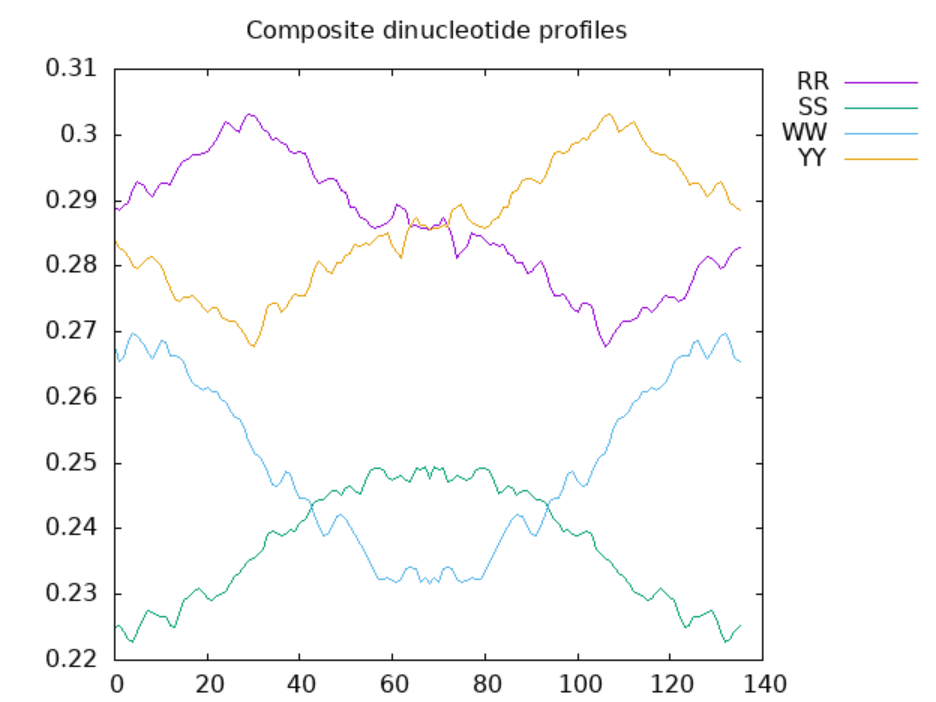
